# Google Cloud CMIP6 Public Data: Basic Python Example

This notebooks shows how to query the catalog and load the data using python

In [16]:
#! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis

In [17]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import regionmask
import json
import os
from pathlib import Path

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [18]:
plt.rcParams['figure.figsize'] = 12, 6

In [19]:
import xarray as xr

url = "gs://cmip6/CMIP6/ScenarioMIP/AS-RCEC/TaiESM1/ssp245/r1i1p1f1/Amon/tas/gn/v20201124/"
df = xr.open_zarr(url, consolidated=False)

print(df)

<xarray.Dataset>
Dimensions:    (lat: 192, bnds: 2, lon: 288, time: 1032)
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, bnds) float64 ...
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 ...
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object ...
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float32 ...
Attributes: (12/51)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               ScenarioMIP
    branch_method:             Hybrid-restart from year 2015-01-01 of historical
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     60225.0
    ...                        ...
    table_id:                  Amon
    table_info:                Creation Date:(24 July 2019) MD5:0bb394a3

## Exploring New Dataset: TaiESM1 ssp245 Scenario Data

This is future temperature projection data (2015-2100) from the TaiESM1 model by AS-RCEC under the ssp245 scenario.


In [20]:
# Basic dataset information
print("Dataset Dimension Information:")
print(f"Time dimension: {df.dims['time']} time points")
print(f"Latitude dimension: {df.dims['lat']} grid points")
print(f"Longitude dimension: {df.dims['lon']} grid points")
print(f"\nTime range: {df.time.values[0]} to {df.time.values[-1]}")
print(f"Latitude range: {df.lat.values.min():.2f}°N to {df.lat.values.max():.2f}°N")
print(f"Longitude range: {df.lon.values.min():.2f}°E to {df.lon.values.max():.2f}°E")
print(f"\nVariable names: {list(df.data_vars)}")
print(f"\nModel information: {df.attrs.get('source_id', 'N/A')}")
print(f"Experiment type: {df.attrs.get('experiment_id', 'N/A')}")


Dataset Dimension Information:
Time dimension: 1032 time points
Latitude dimension: 192 grid points
Longitude dimension: 288 grid points

Time range: 2015-01-16 12:00:00 to 2100-12-16 12:00:00
Latitude range: -90.00°N to 90.00°N
Longitude range: 0.00°E to 358.75°E

Variable names: ['tas']

Model information: TaiESM1
Experiment type: ssp245


In [21]:
# Convert xarray data to DataFrame for statistical display
# Select data from the first time point as an example
df_sample = df.tas.isel(time=0).to_dataframe().reset_index()
print("Statistical data for the first time point (2015-01):")
print(df_sample['tas'].describe())
print(f"\nTotal grid points: {len(df_sample)}")
print(f"Valid data points: {df_sample['tas'].notna().sum()}")


Statistical data for the first time point (2015-01):
count    55296.000000
mean       276.216644
std         21.749599
min        228.313370
25%        257.889618
50%        281.288010
75%        296.171036
max        306.757477
Name: tas, dtype: float64

Total grid points: 55296
Valid data points: 55296


## Country-Level Temperature Aggregation (2025)


In [22]:
# Compute area-weighted mean surface air temperature per country for 2025
os.environ.setdefault('REGIONMASK_NE_ENGINE', 'pyogrio')
countries_regions = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

# Average tas across all months in 2025
tas_2025 = df.tas.sel(time=slice('2025-01-01', '2025-12-31')).mean(dim='time')

# Create latitude-based cosine weights (approximate grid cell area weights)
lat_weights = xr.apply_ufunc(np.cos, np.deg2rad(tas_2025.lat))
lat_weights = lat_weights / lat_weights.mean()
weights = lat_weights.broadcast_like(tas_2025)

# Build a 3D mask (region, lat, lon) and compute weighted means
mask_3d = countries_regions.mask_3D(tas_2025)
weighted_sum = (tas_2025 * weights * mask_3d).sum(dim=('lat', 'lon'))
weight_totals = (weights * mask_3d).sum(dim=('lat', 'lon'))
country_means_kelvin = weighted_sum / weight_totals

# Convert to Celsius for readability
country_means_celsius = country_means_kelvin - 273.15

# Assemble a DataFrame for inspection
records = []
num_regions = country_means_celsius.sizes.get('region', 0)
for idx in range(num_regions):
    iso3 = countries_regions.abbrevs[idx] if idx < len(countries_regions.abbrevs) else None
    name = countries_regions.names[idx] if idx < len(countries_regions.names) else None
    value = country_means_celsius.isel(region=idx).item()
    if iso3 in (None, '', '-99') or np.isnan(value):
        continue
    records.append({'iso3': iso3, 'name': name, 'temperature_c': float(value)})

country_summary_df = pd.DataFrame(records).reset_index(drop=True)
country_summary_df.head(10)


,iso3,name,temperature_c
0,FJ,Fiji,27.245752
1,TZ,Tanzania,22.589929
2,WS,W. Sahara,25.822747
3,CA,Canada,-2.906039
4,US,United States of America,11.210032
5,KZ,Kazakhstan,11.322232
6,UZ,Uzbekistan,17.079614
7,PG,Papua New Guinea,24.263697
8,INDO,Indonesia,25.665914
9,AR,Argentina,15.929831


In [23]:
# Export ISO3 -> temperature mapping (Celsius) for the web visualization
output_dir = Path('docs/data')
output_dir.mkdir(parents=True, exist_ok=True)

country_temp_map = {}
num_regions = country_means_celsius.sizes.get('region', 0)
for idx in range(num_regions):
    iso3 = countries_regions.abbrevs[idx] if idx < len(countries_regions.abbrevs) else None
    if iso3 in (None, '', '-99'):
        continue
    value = country_means_celsius.isel(region=idx).item()
    if np.isnan(value):
        continue
    country_temp_map[iso3] = round(float(value), 2)

output_path = output_dir / 'tas_2025_by_country.json'
with output_path.open('w', encoding='utf-8') as f:
    json.dump(country_temp_map, f, indent=2)

print(f"Saved {len(country_temp_map)} country averages to {output_path}")


Saved 168 country averages to docs\data\tas_2025_by_country.json


In [24]:
# Create time series statistical DataFrame
# Calculate global average temperature for each time point
global_mean = df.tas.mean(dim=['lat', 'lon'])

# Extract year and month directly from xarray DataArray (supports cftime objects)
# Use .dt accessor to extract directly from time coordinate
years = global_mean.time.dt.year.values
months = global_mean.time.dt.month.values

# Create DataFrame
global_mean_df = pd.DataFrame({
    'time': global_mean.time.values,
    'tas': global_mean.values,
    'year': years,
    'month': months
})

# Statistics by year
yearly_stats = global_mean_df.groupby('year')['tas'].agg(['mean', 'min', 'max', 'std']).reset_index()
print("Annual Global Average Temperature Statistics:")
print(yearly_stats.head(10))
print("\n...")
print(yearly_stats.tail(10))


Annual Global Average Temperature Statistics:
   year        mean         min         max       std
0  2015  278.100067  275.934021  281.067505  1.778437
1  2016  278.349030  276.226715  281.055115  1.719881
2  2017  278.325104  276.534302  281.130737  1.759589
3  2018  278.117767  275.901550  280.959839  1.896403
4  2019  278.088287  276.124023  280.581329  1.797979
5  2020  278.275604  275.779938  281.090332  1.862352
6  2021  278.396088  276.329834  281.001404  1.639866
7  2022  278.563324  276.386078  281.083252  1.619366
8  2023  278.582062  276.145966  281.408875  1.735967
9  2024  278.576080  276.521149  281.106049  1.721147

...
    year        mean         min         max       std
76  2091  281.533630  278.876709  283.678741  1.556158
77  2092  281.548859  279.403656  283.816681  1.454412
78  2093  281.623932  279.261871  283.645233  1.430741
79  2094  281.706970  279.639099  283.931396  1.506102
80  2095  281.696167  279.297241  283.778717  1.507842
81  2096  281.989807  280

## Visualization Analysis


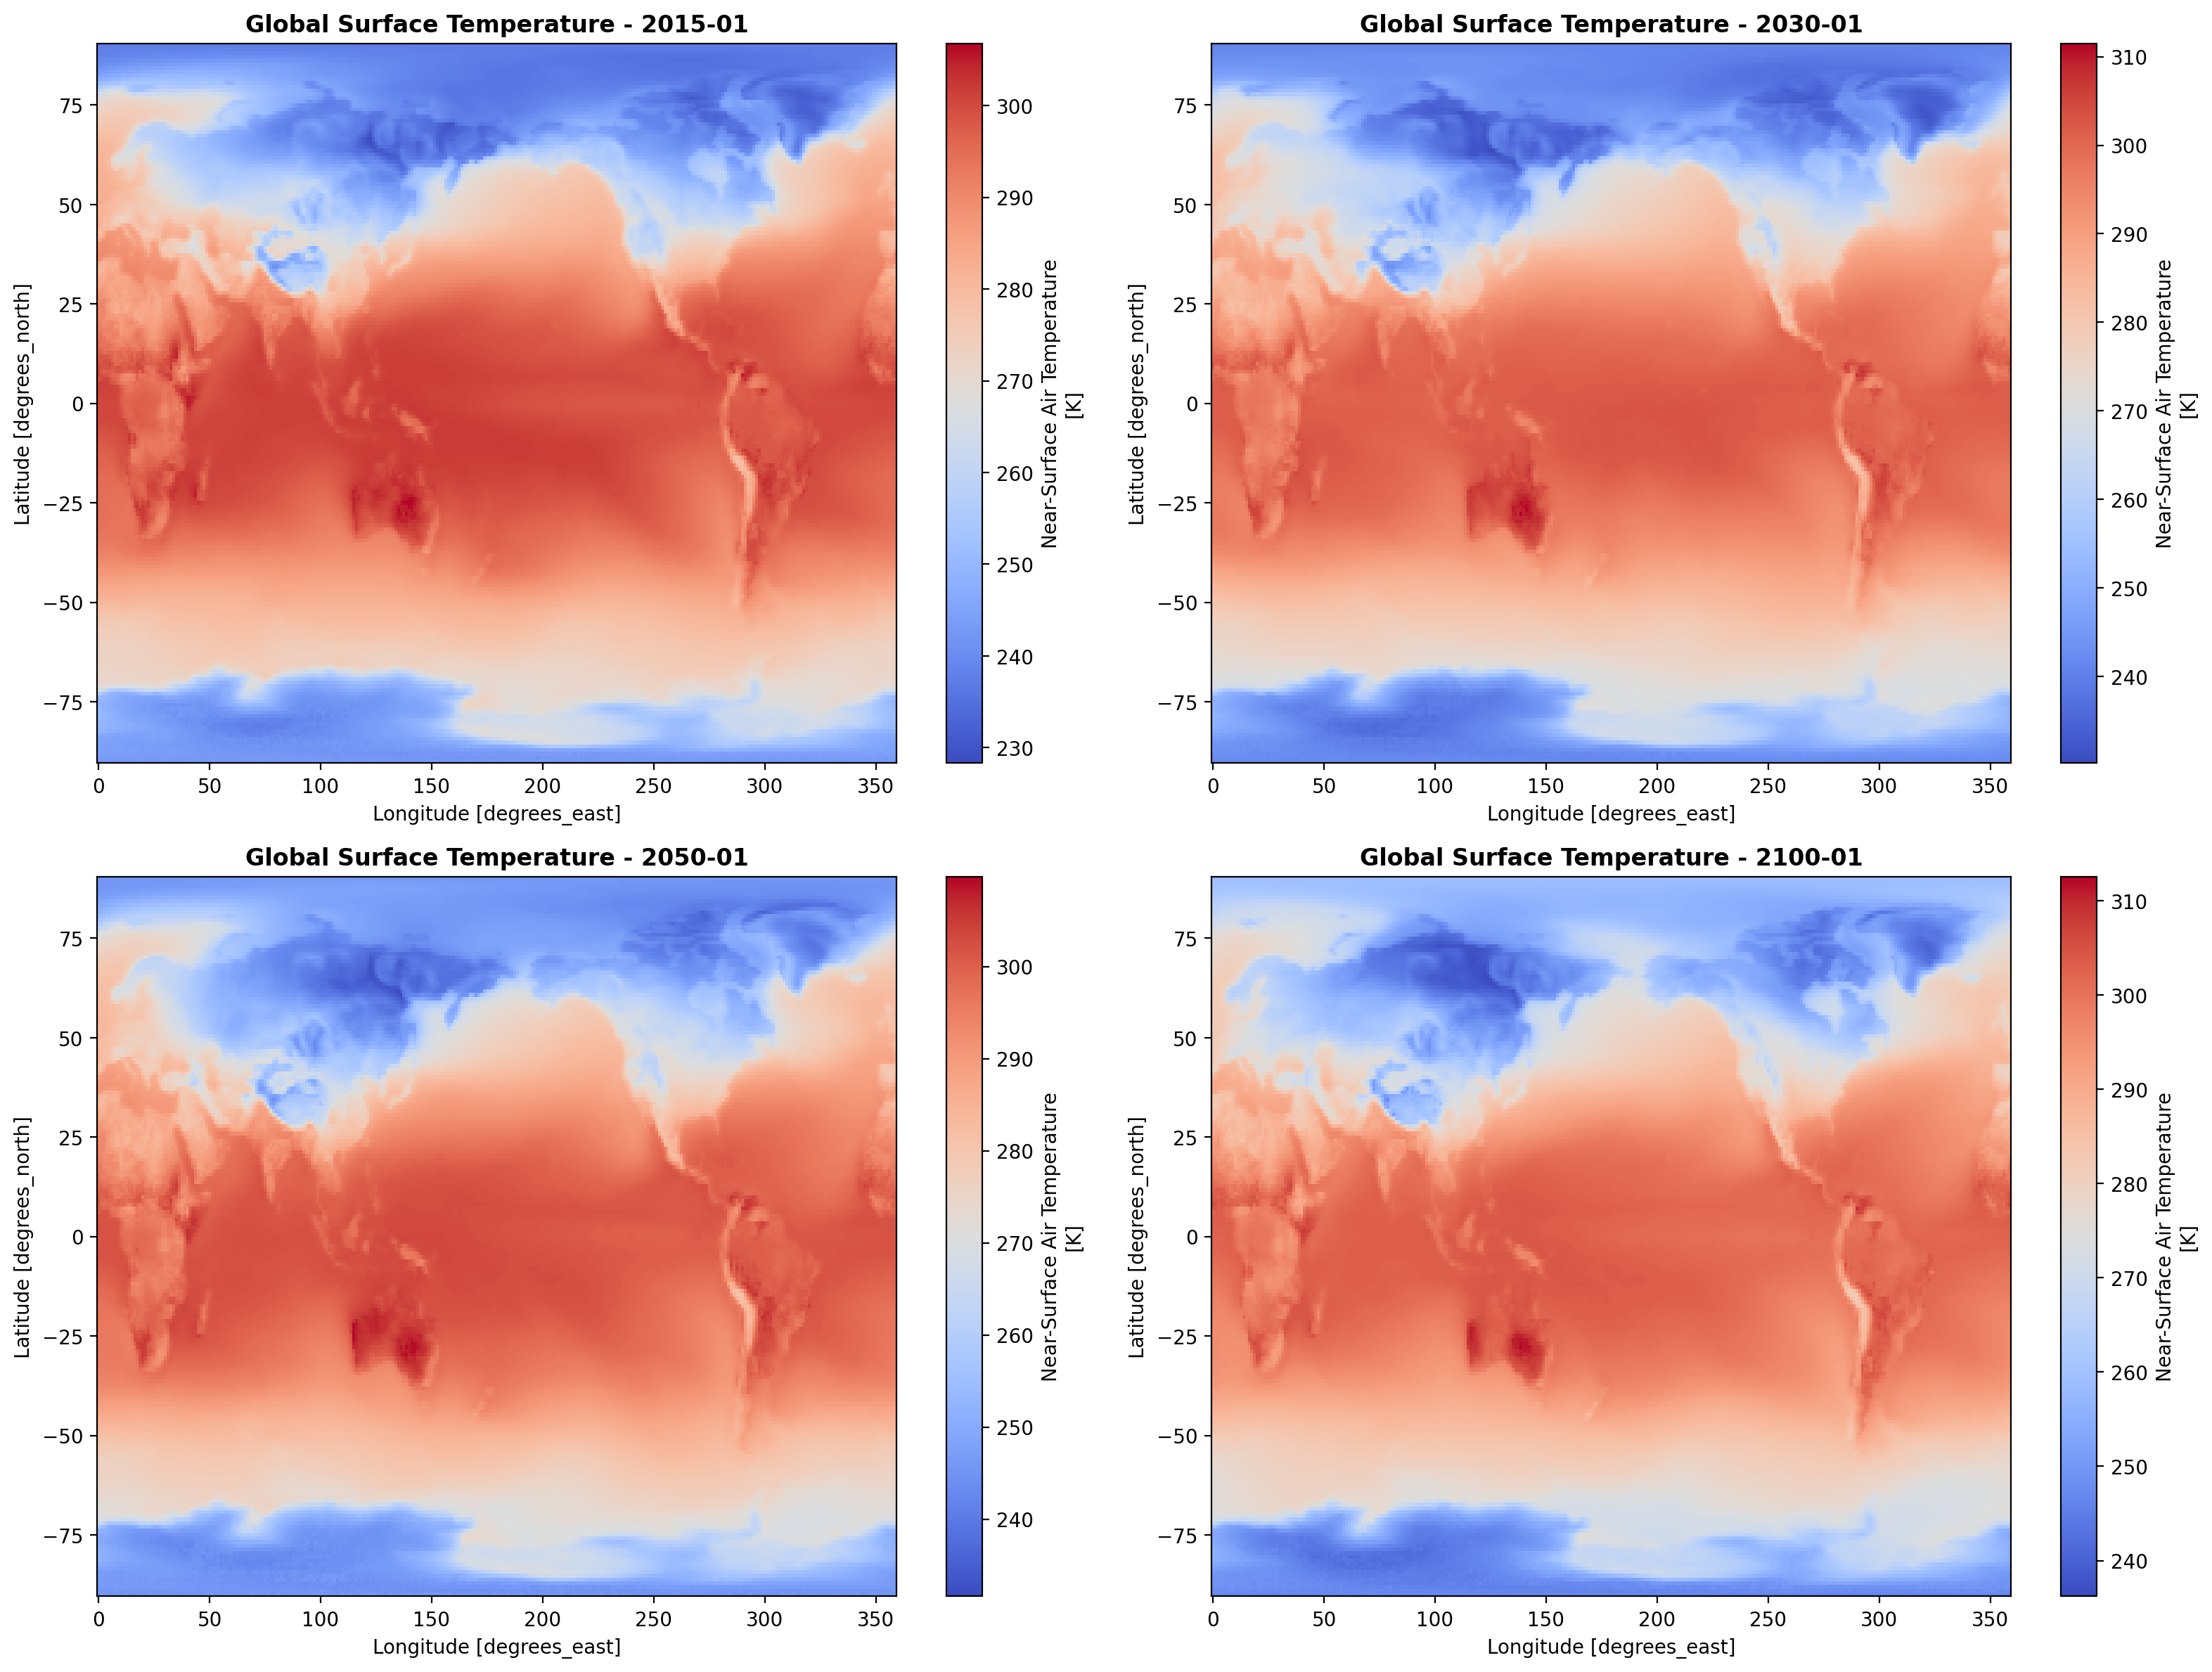

In [25]:
# 1. Plot global temperature distribution at specific time points
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Select different time points for comparison
time_points = ['2015-01', '2030-01', '2050-01', '2100-01']
for idx, time_pt in enumerate(time_points):
    ax = axes[idx // 2, idx % 2]
    df.tas.sel(time=time_pt).squeeze().plot(ax=ax, cmap='coolwarm', add_colorbar=True)
    ax.set_title(f'Global Surface Temperature - {time_pt}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


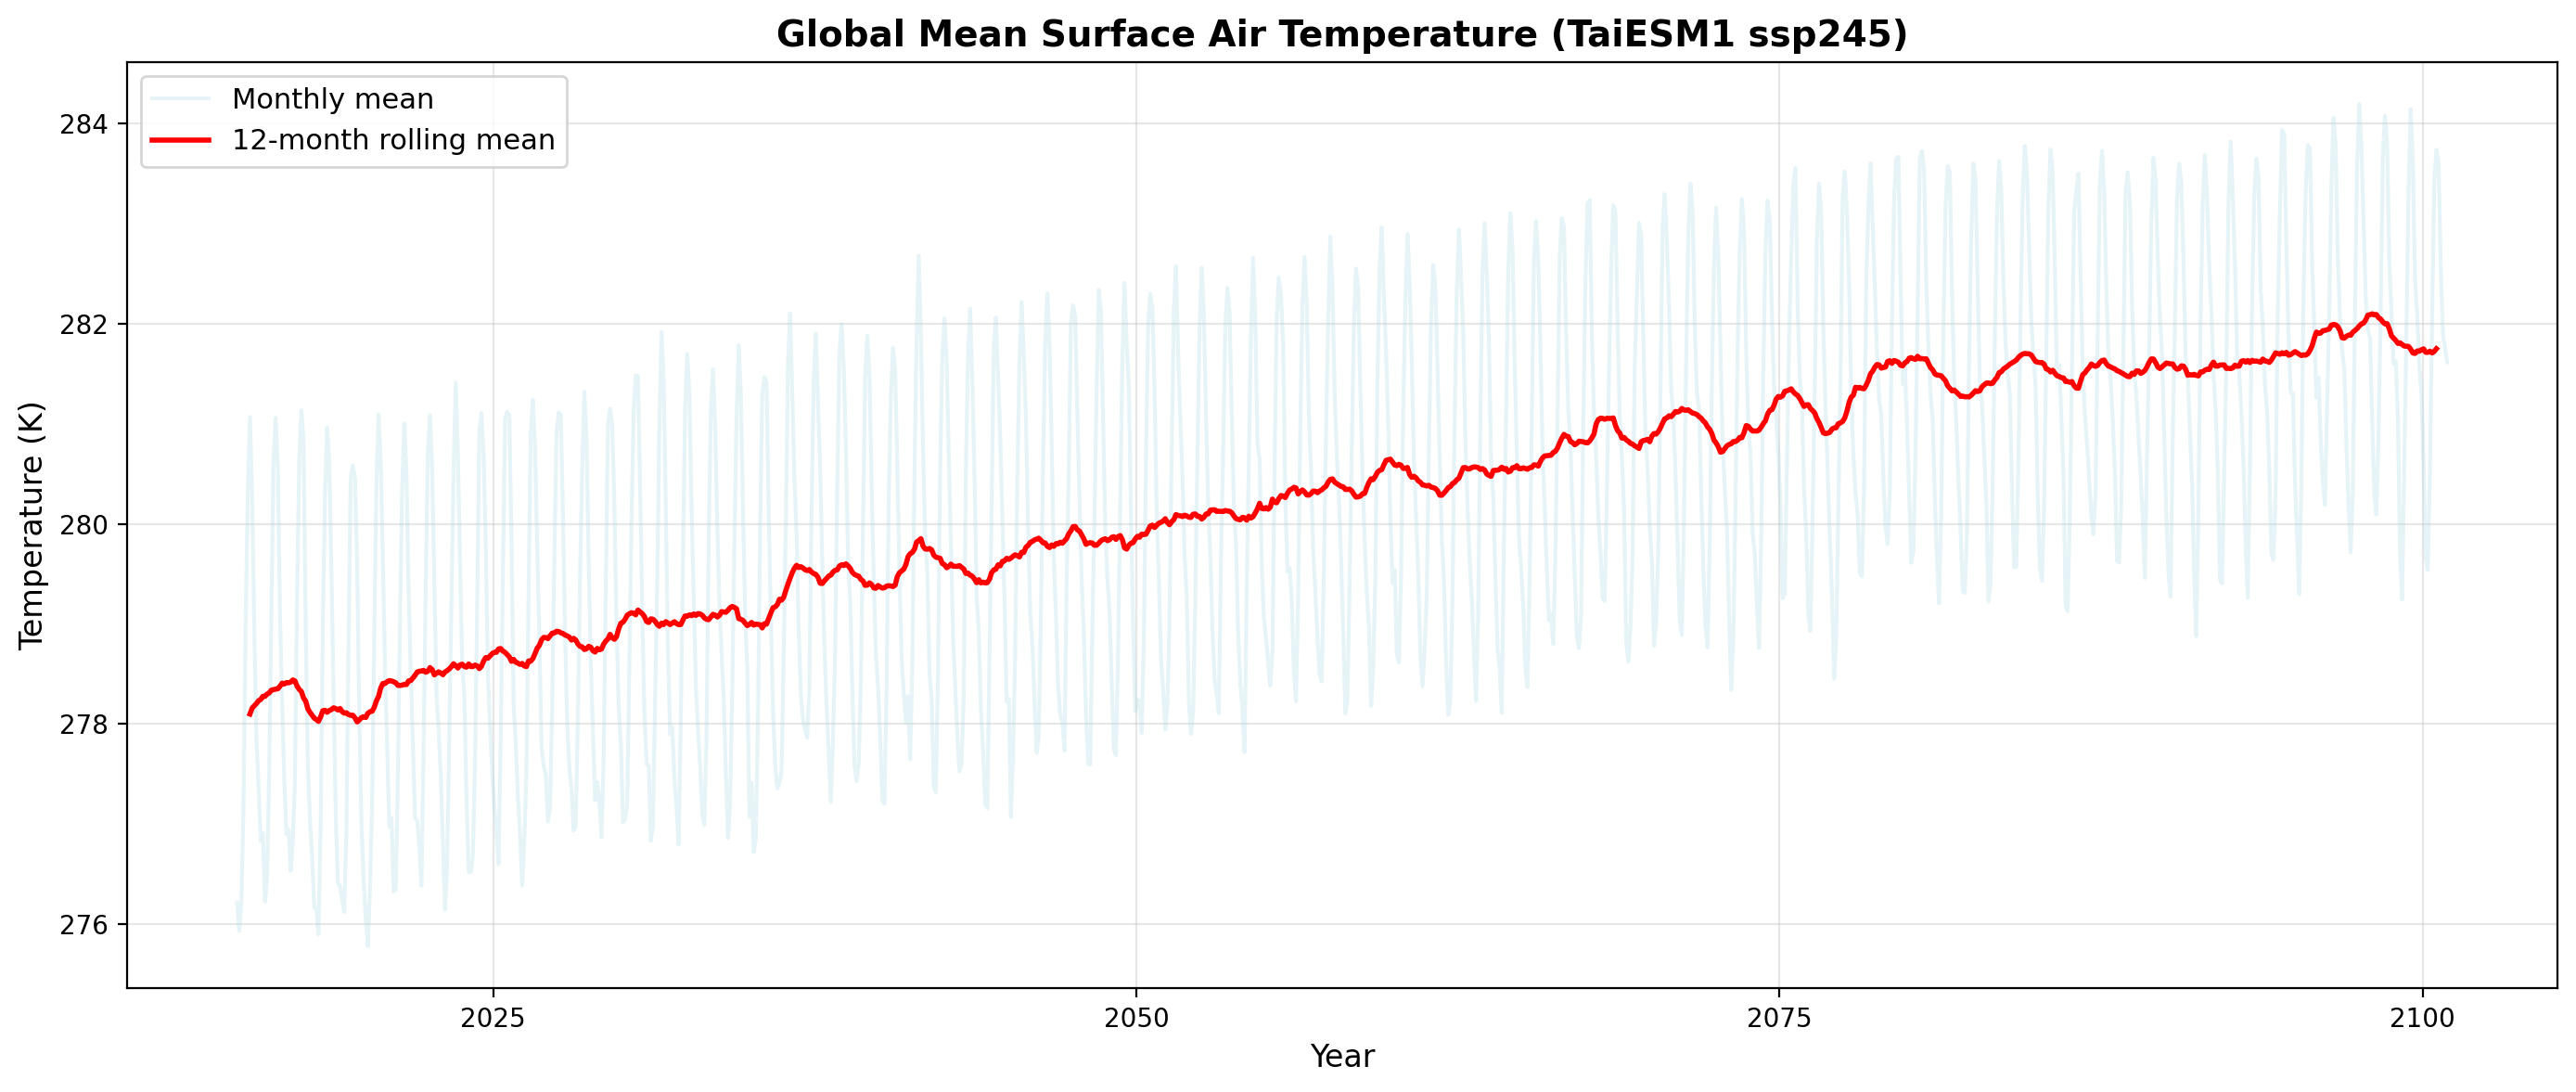

In [26]:
# 2. Global average temperature time series
global_mean = df.tas.mean(dim=['lat', 'lon'])
global_mean.load()  # Load data into memory

plt.figure(figsize=(14, 6))
global_mean.plot(label='Monthly mean', alpha=0.3, color='lightblue')
global_mean.rolling(time=12, center=True).mean().plot(label='12-month rolling mean', color='red', linewidth=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.title('Global Mean Surface Air Temperature (TaiESM1 ssp245)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


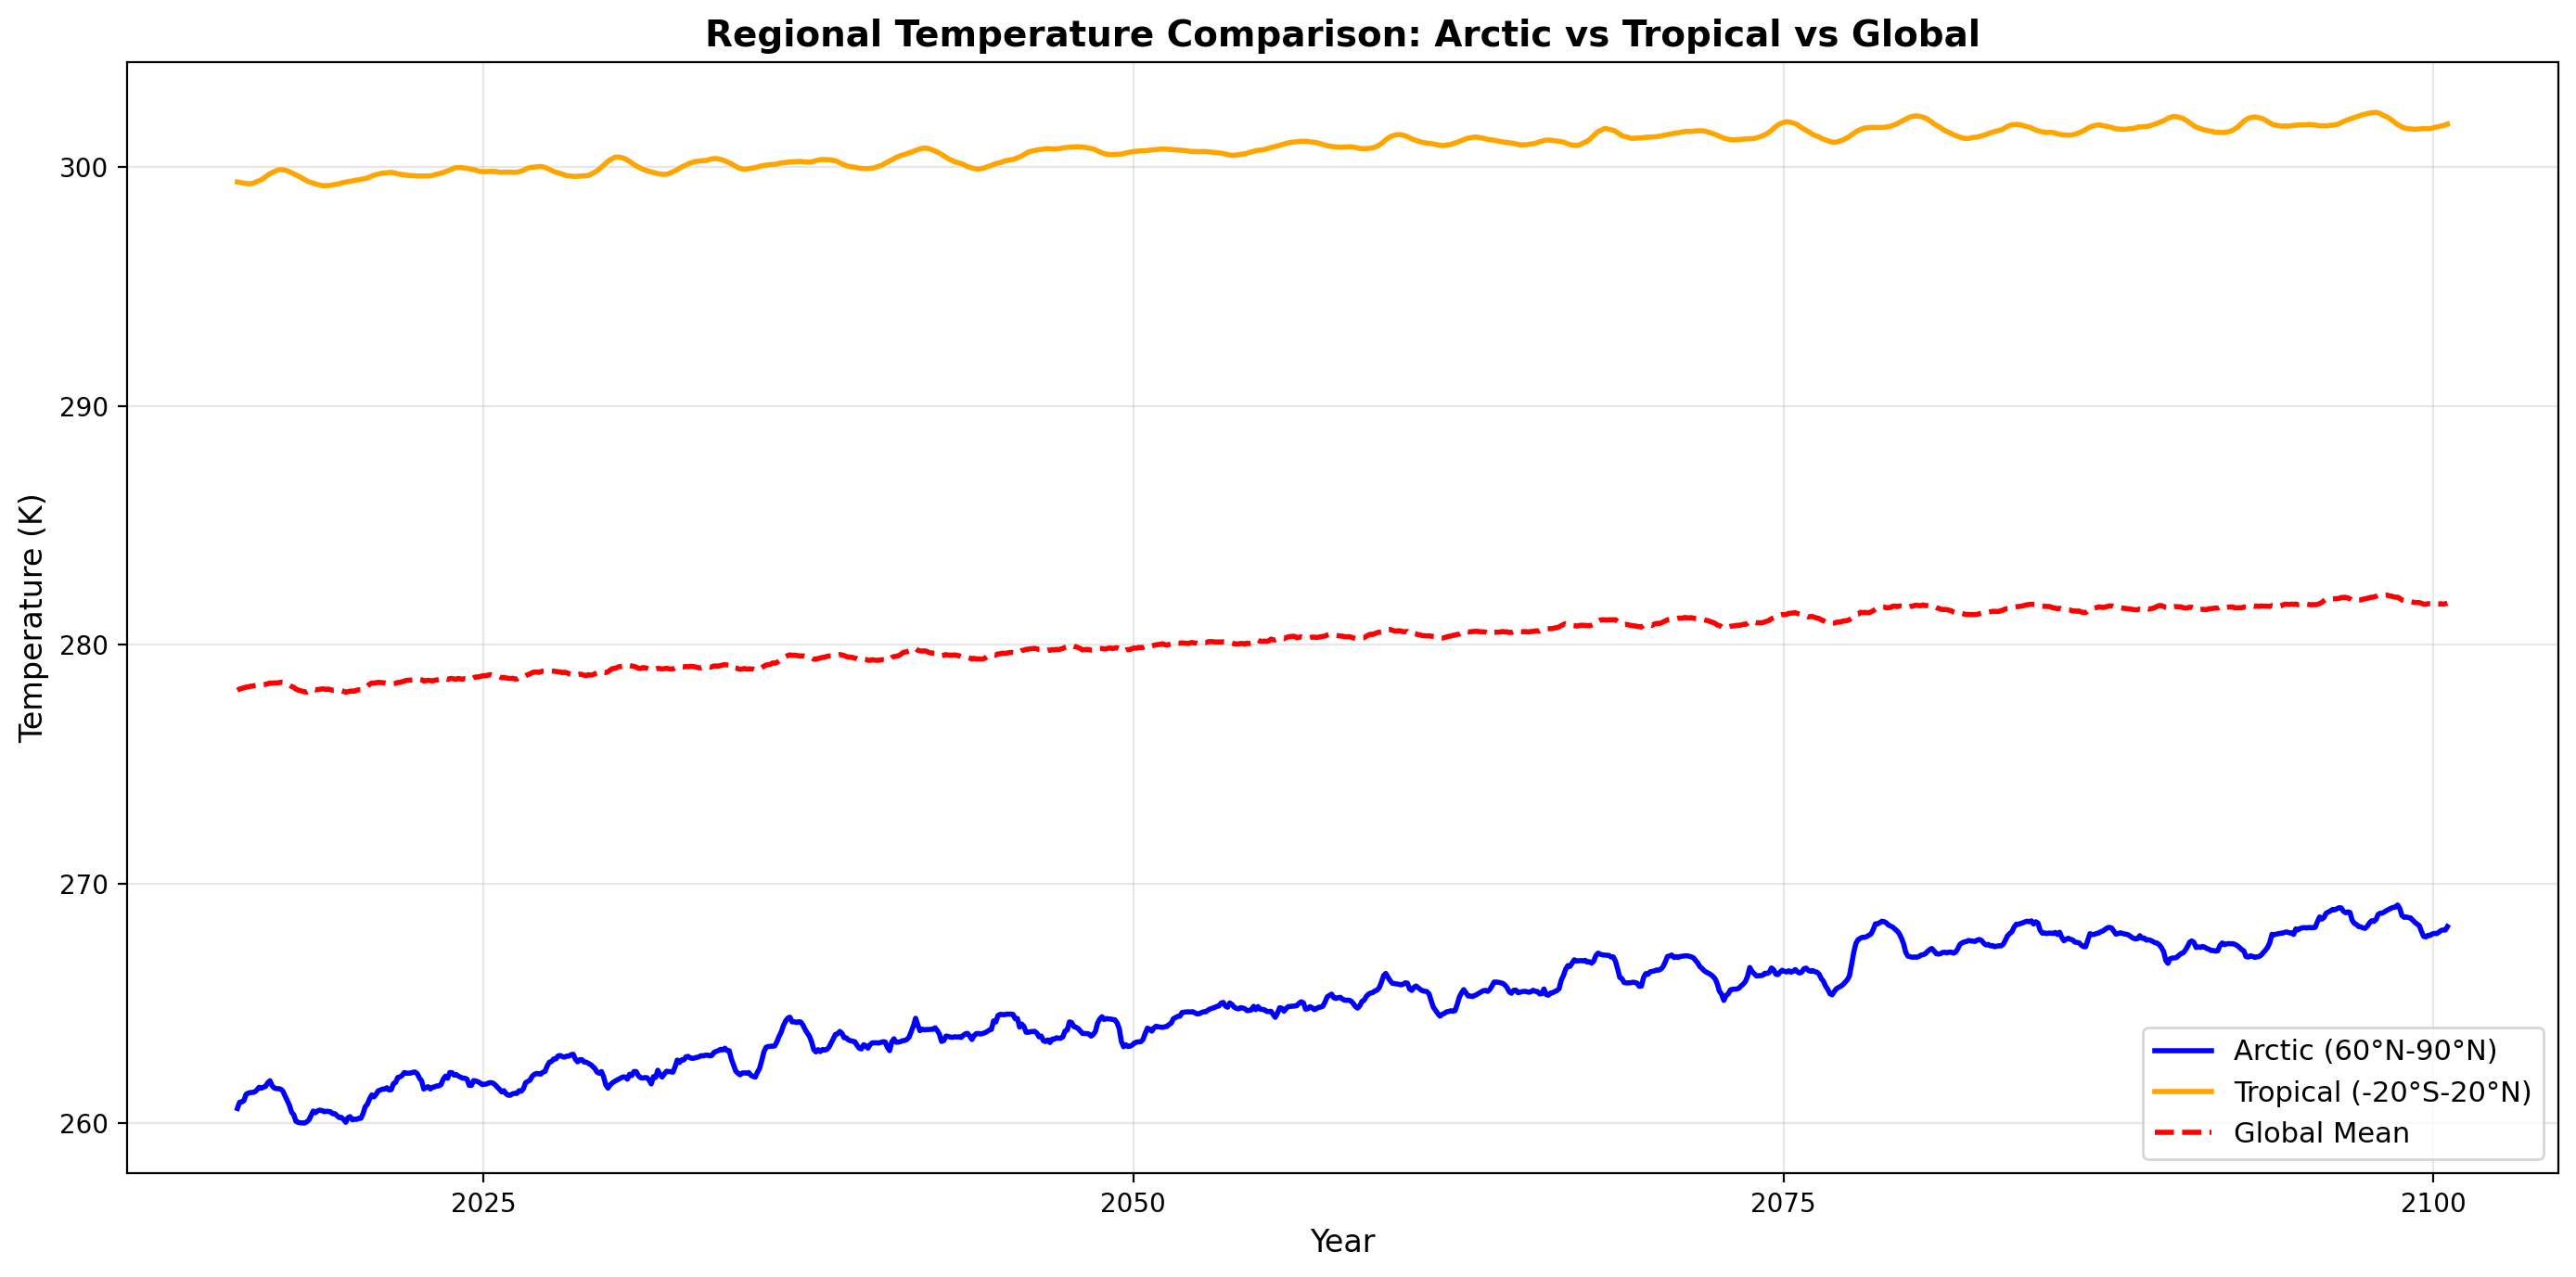

In [27]:
# 3. Regional analysis: Arctic temperature changes
arctic_data = df.tas.sel(lat=slice(60, 90))  # Select 60°N-90°N
arctic_mean = arctic_data.mean(dim=['lat', 'lon'])
arctic_mean.load()

tropical_data = df.tas.sel(lat=slice(-20, 20))  # Select tropical region
tropical_mean = tropical_data.mean(dim=['lat', 'lon'])
tropical_mean.load()

plt.figure(figsize=(14, 7))
arctic_mean.rolling(time=12, center=True).mean().plot(label='Arctic (60°N-90°N)', color='blue', linewidth=2)
tropical_mean.rolling(time=12, center=True).mean().plot(label='Tropical (-20°S-20°N)', color='orange', linewidth=2)
global_mean.rolling(time=12, center=True).mean().plot(label='Global Mean', color='red', linewidth=2, linestyle='--')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.title('Regional Temperature Comparison: Arctic vs Tropical vs Global', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


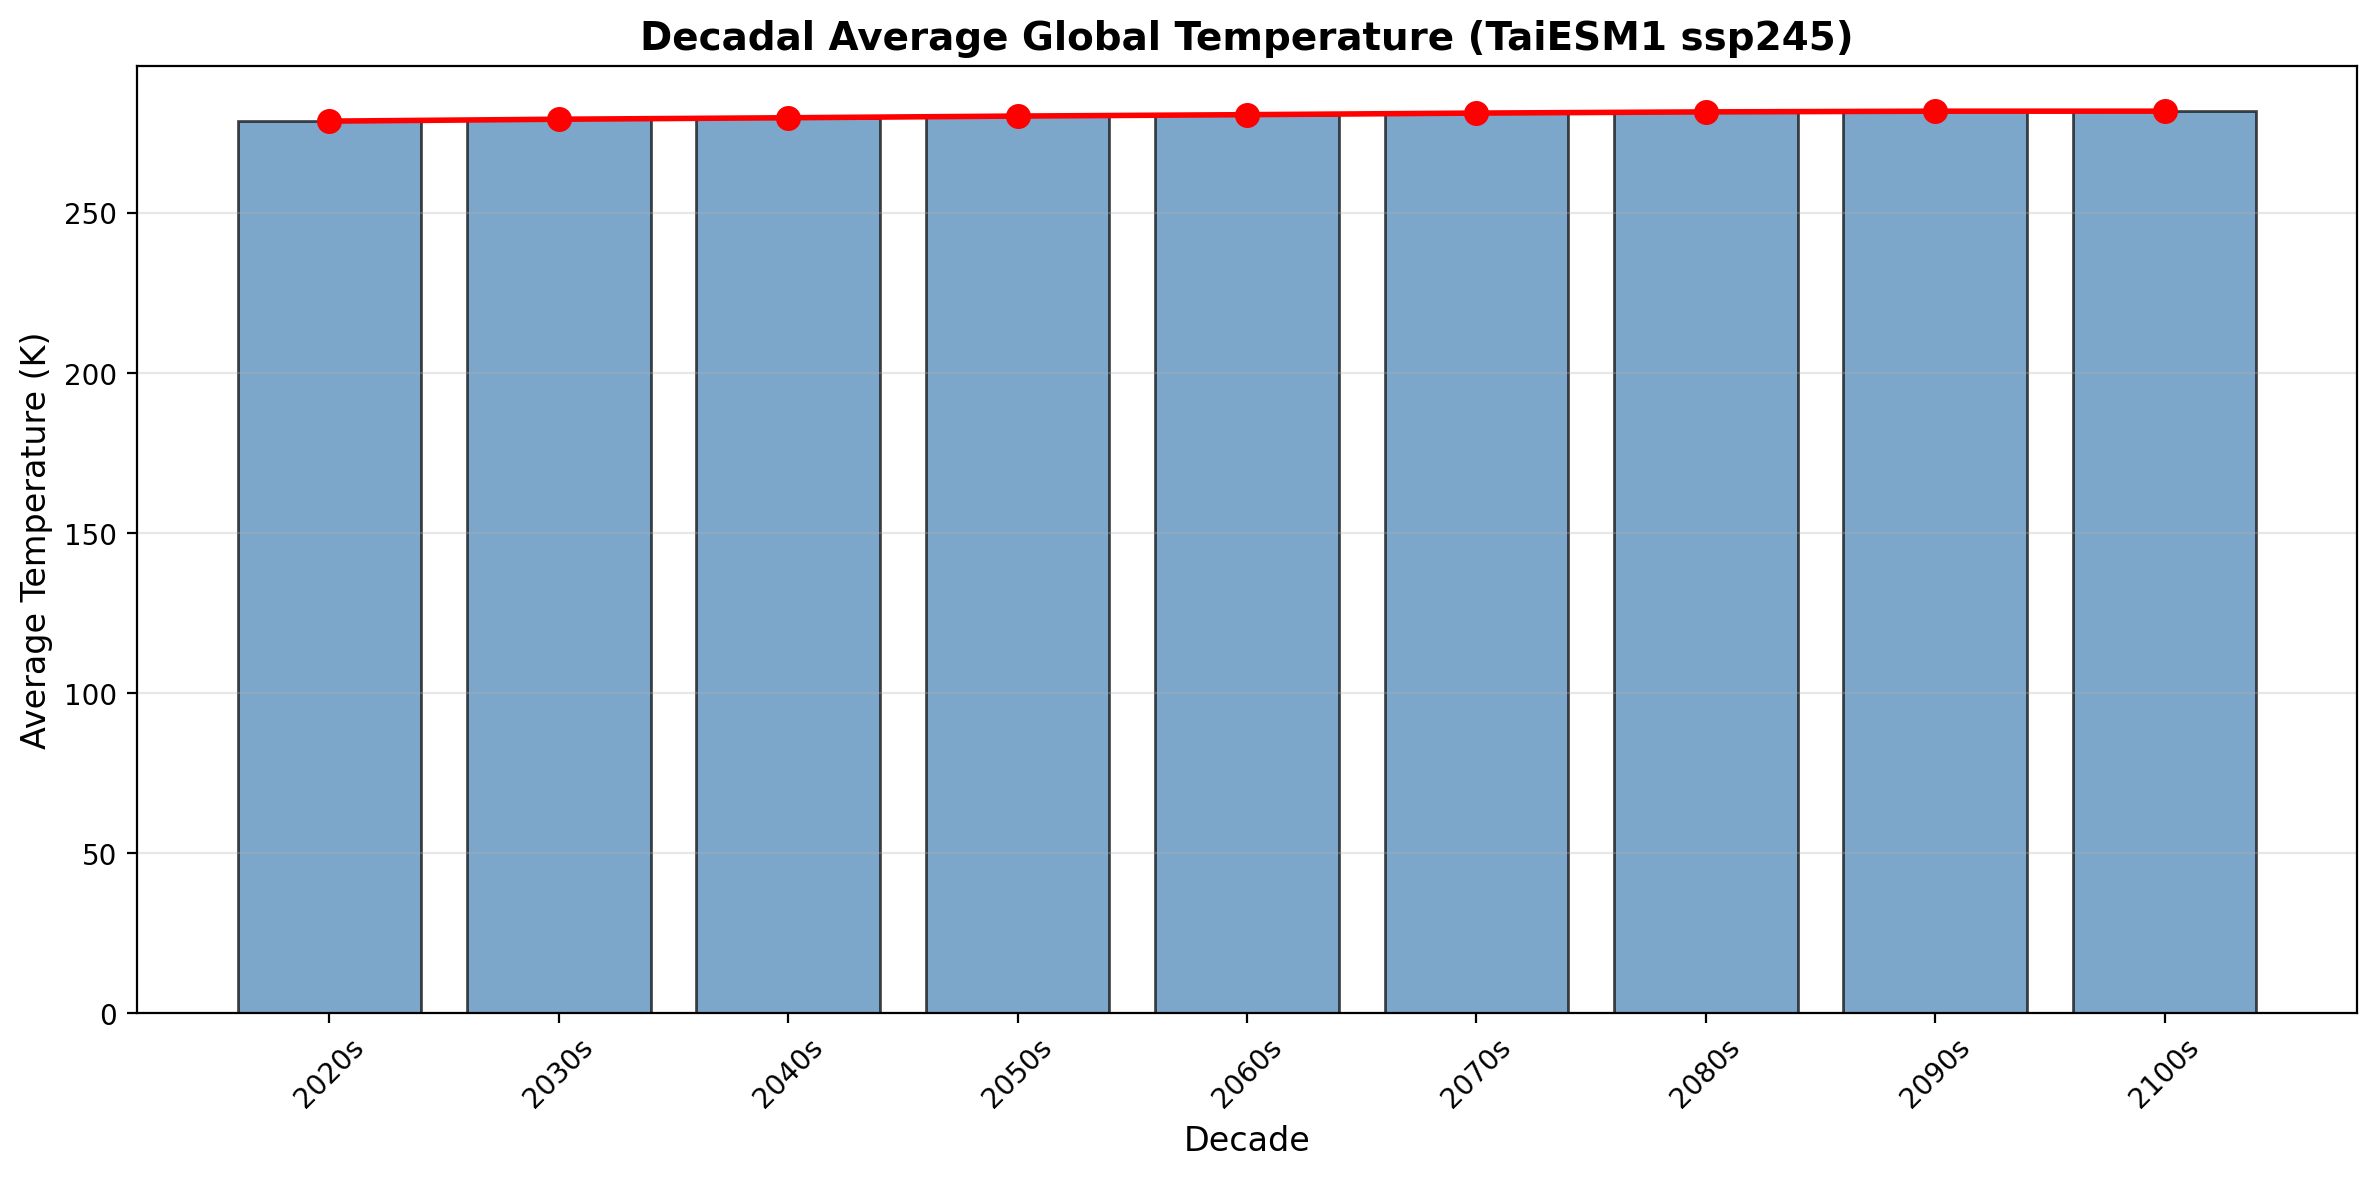


Decadal Average Temperature Statistics:
  Decade   Avg_Temp
0  2020s  278.63058
1  2030s  279.22522
2  2040s  279.68536
3  2050s  280.21313
4  2060s  280.64923
5  2070s  281.14276
6  2080s  281.51553
7  2090s   281.7358
8  2100s  281.74725


In [28]:
# 4. Temperature change trend analysis (by decade)
# Calculate average temperature for each 10-year period
decades = {}
for year in range(2020, 2110, 10):
    start_year = year
    end_year = min(year + 9, 2100)
    decade_data = df.tas.sel(time=slice(f'{start_year}-01', f'{end_year}-12'))
    decades[f'{start_year}s'] = decade_data.mean(dim=['lat', 'lon', 'time']).values

decade_df = pd.DataFrame(list(decades.items()), columns=['Decade', 'Avg_Temp'])
decade_df = decade_df.sort_values('Decade')

plt.figure(figsize=(12, 6))
plt.bar(decade_df['Decade'], decade_df['Avg_Temp'], color='steelblue', alpha=0.7, edgecolor='black')
plt.plot(decade_df['Decade'], decade_df['Avg_Temp'], color='red', marker='o', linewidth=2, markersize=8)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Average Temperature (K)', fontsize=12)
plt.title('Decadal Average Global Temperature (TaiESM1 ssp245)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDecadal Average Temperature Statistics:")
print(decade_df)


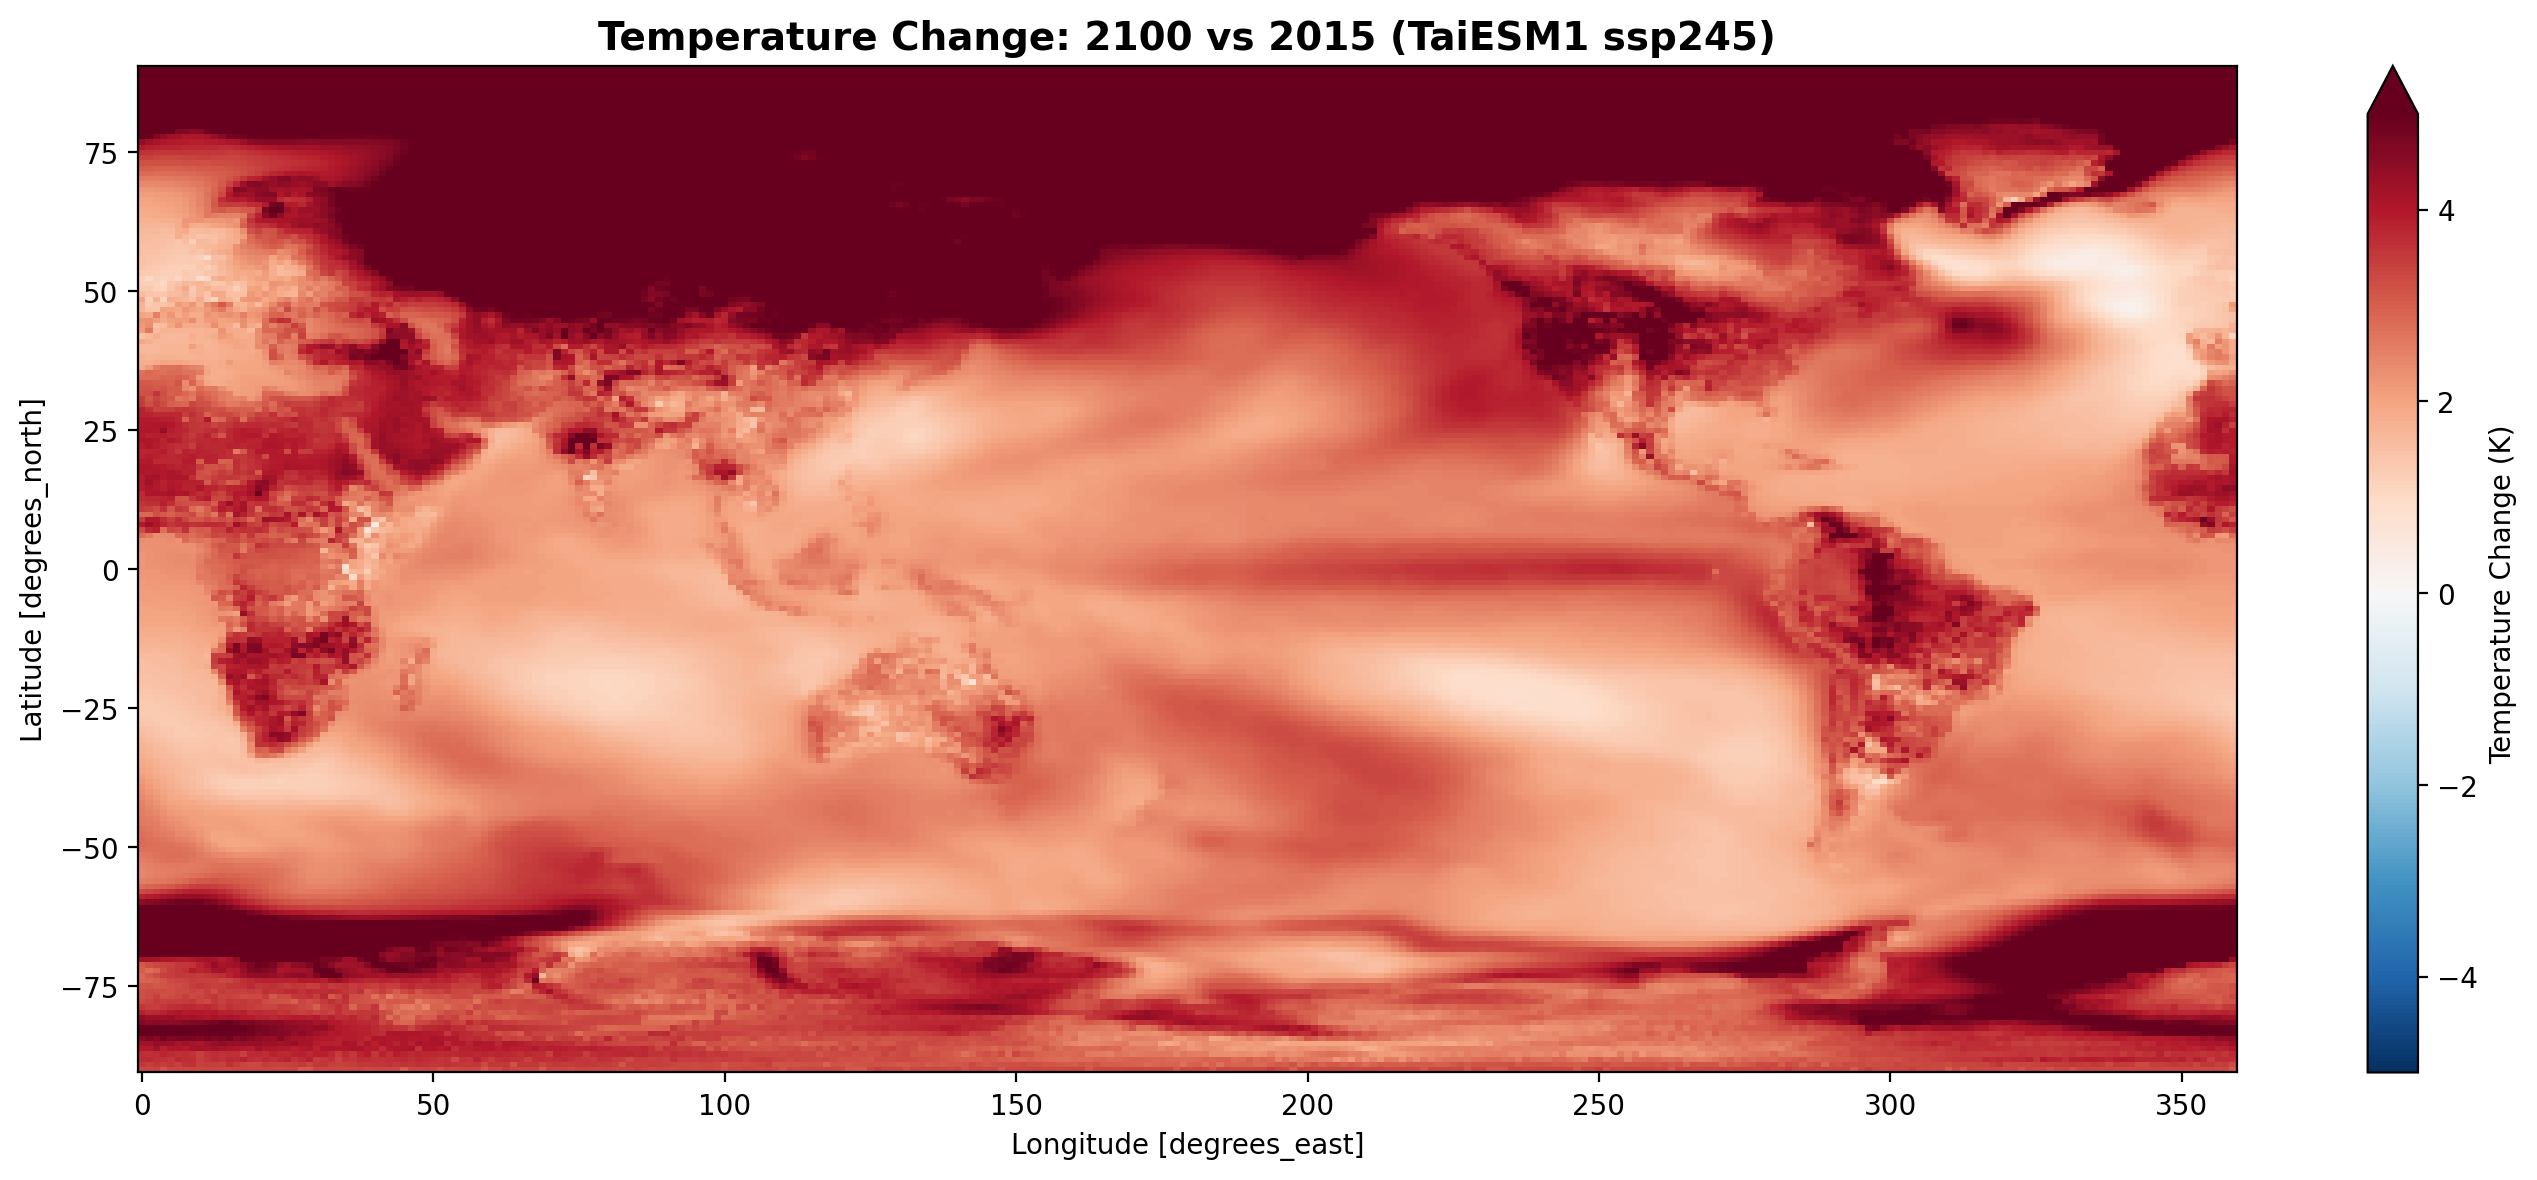


Global average temperature change: 3.65 K
Maximum warming region: 13.56 K
Minimum warming region: 0.22 K


In [29]:
# 5. Spatial distribution of temperature change (2100 relative to 2015)
temp_2015 = df.tas.sel(time='2015').mean(dim='time')
temp_2100 = df.tas.sel(time='2100').mean(dim='time')
temp_change = temp_2100 - temp_2015
temp_change.load()

plt.figure(figsize=(14, 6))
temp_change.plot(cmap='RdBu_r', center=0, vmin=-5, vmax=5, cbar_kwargs={'label': 'Temperature Change (K)'})
plt.title('Temperature Change: 2100 vs 2015 (TaiESM1 ssp245)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nGlobal average temperature change: {temp_change.mean().values:.2f} K")
print(f"Maximum warming region: {temp_change.max().values:.2f} K")
print(f"Minimum warming region: {temp_change.min().values:.2f} K")


In [30]:
# 6. Create detailed statistical DataFrame display
# Statistics by year and month
yearly_monthly = global_mean_df.groupby(['year', 'month'])['tas'].mean().reset_index()
yearly_monthly_pivot = yearly_monthly.pivot(index='year', columns='month', values='tas')
yearly_monthly_pivot.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("Annual Monthly Temperature Statistics Table (First 10 years):")
print(yearly_monthly_pivot.head(10).round(2))
print("\nAnnual Monthly Temperature Statistics Table (Last 10 years):")
print(yearly_monthly_pivot.tail(10).round(2))


Annual Monthly Temperature Statistics Table (First 10 years):
             Jan         Feb         Mar         Apr         May         Jun  \
year                                                                           
2015  276.220001  275.929993  276.200012  277.170013  279.000000  280.260010   
2016  276.910004  276.230011  276.459991  277.529999  279.130005  280.660004   
2017  276.950012  276.529999  276.820007  277.429993  279.290009  280.640015   
2018  276.170013  276.160004  275.899994  277.010010  278.950012  280.279999   
2019  276.380005  276.260010  276.119995  276.910004  278.790009  280.459991   
2020  276.049988  275.779999  276.350006  277.190002  278.890015  280.369995   
2021  277.059998  276.329987  276.350006  277.399994  279.029999  280.329987   
2022  277.029999  276.779999  276.390015  277.709991  279.359985  280.720001   
2023  276.799988  276.149994  276.589996  277.869995  279.220001  280.519989   
2024  276.519989  276.519989  276.679993  277.579987  279.